In [30]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import galsim
import numpy as np
import fpfs
import matplotlib.pyplot as plt

import batsim.pltutil as batplot
from batsim.stamp import Stamp
from batsim.transforms import IaTransform, LensTransform

### Fit A_IA galaxy scale dependence

[0.00136207 0.82404653]
0.0006810368036279025
0.7254688891020777
0.7254688891020777
0.7254688891020776


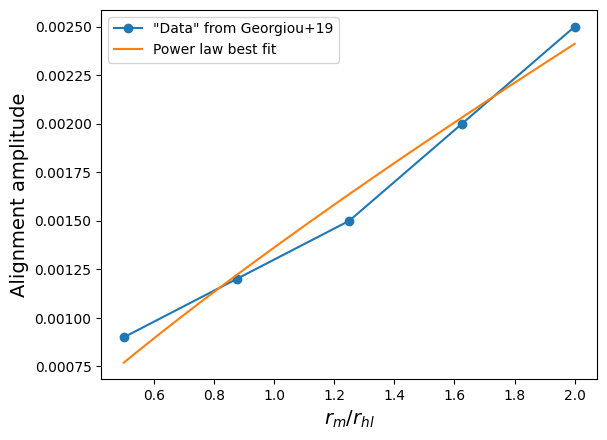

In [31]:
# fit curve to GAMA results in Georgieu 2019
from scipy.optimize import curve_fit

rwf = np.linspace(0.5,2.0,5)

A_IA = [0.0009, 0.0012, 0.0015, 0.002, 0.0025]

def power_law(rwf, m, b):
    return m * rwf**b

var, covs = curve_fit(power_law, rwf, A_IA)
print(var)
rwf_dense = np.linspace(0.5,2.0,100)
A_dense = var[0] * rwf_dense**var[1]
A_dense_2 = 2*var[0] * rwf_dense**var[1]
A_dense_3 = 3*var[0] * rwf_dense**var[1]
A_dense_10 = 10*var[0] * rwf_dense**var[1]

AIA_fid = galsim.Shear(e1=var[0]).g1
print(AIA_fid)

plt.plot(rwf, A_IA, marker='o', label='"Data" from Georgiou+19')
plt.plot(rwf_dense, A_dense, label='Power law best fit')
plt.legend()
plt.ylabel('Alignment amplitude', fontsize=14)
plt.xlabel(r'$r_{m}/r_{hl}$', fontsize=14)

print(A_dense[30]/A_dense[60])
print(A_dense_2[30]/A_dense_2[60])
print(A_dense_3[30]/A_dense_3[60])

### Test with a power of 0 (constant shear)

Text(0.5, 1.0, 'Preliminary')

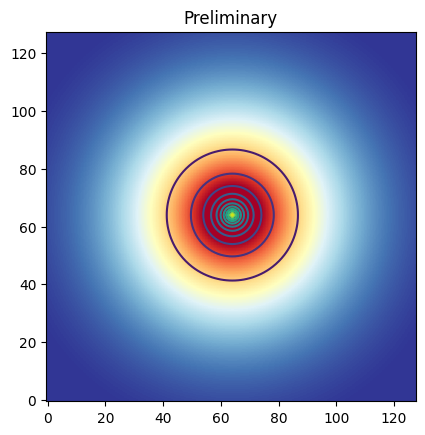

In [102]:
## create a galaxy with raidall dependent shear
flux = 40
scale = 60000
hlr = 1.4e6
nn = 128
trunc = 0

# create galaxy to be sampled by shear stamp objects
sersic_gal = galsim.Sersic(n=1.5, half_light_radius=hlr, flux=flux, trunc=trunc)

# # # apply lensing shear to galaxy
stamp = Stamp(nn=nn, scale=scale, centering='fpfs')

# define ia shear as a % of lensing
ia = IaTransform(beta=0, center=[0,0], phi=np.radians(0), scale=scale, hlr=hlr)
stamp.transform_grids(ia)

# get galaxy array from stamp object
gal_array = stamp.sample_galaxy(sersic_gal)
batplot.make_plot_image(gal_array)
plt.contour(gal_array, levels=15)
plt.title('Preliminary')

In [103]:
# define PSF
psf_array = np.zeros(stamp.shape)
psf_array[nn // 2, nn // 2] = 1

coords = np.array([nn//2, nn//2])
fpTask  = fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.6)
mms =  fpTask.measure(gal_array, coords)
mms = fpTask.get_results(mms)
ells = fpfs.catalog.fpfs_m2e(mms,const=2000)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp
print("measured shear: %.6f" % shear)

inner_shear = shear

/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 13:58:39 ---  Order of the shear estimator: nnord=4
2023/11/27 13:58:39 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/11/27 13:58:39 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

measured shear: 5317145364989475587432630243213443072.000000


In [110]:
fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=1.2)
mms =  fpTask.measure(gal_array, coords)
mms = fpTask.get_results(mms)
ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp
print("measured shear: %.6f" % shear)

outer_shear = shear

/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 13:59:21 ---  Order of the shear estimator: nnord=4
2023/11/27 13:59:21 ---  Shapelet kernel in configuration space: sigma= 3.2000 arcsec
2023/11/27 13:59:21 ---  Detection kernel in configuration space: sigma= 3.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

measured shear: 186940583910098528760099989878734848.000000


In [58]:
print('a =', inner_shear / outer_shear)
print('Fiducial AIA value', AIA_fid)
print('inner bias = ', AIA_fid - inner_shear)
print('outer bias = ', AIA_fid - outer_shear)

a = 0.9999441154786691
Fiducial AIA value 0.0006810368036279025
inner bias =  -1.5698832707866824e-08
outer bias =  -5.3761252909200787e-08


### Now test with non-zero index

Text(0.5, 1.0, 'Preliminary')

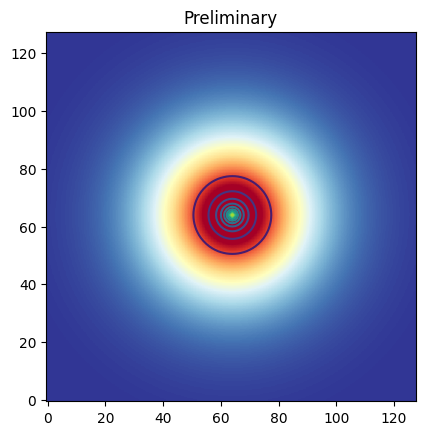

In [59]:
# # # apply lensing shear to galaxy
stamp = Stamp(nn=nn, scale=scale, centering='fpfs')

# define ia shear as a % of lensing
ia = IaTransform(A=0.00136207, center=[0,0], scale=scale, hlr=hlr)
stamp.transform_grids(ia)

# get galaxy array from stamp object
gal_array = stamp.sample_galaxy(sersic_gal)
batplot.make_plot_image(gal_array)
plt.contour(gal_array, levels=15)
plt.title('Preliminary')

In [60]:
coords = np.array([nn//2, nn//2])
fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.6)
mms =  fpTask.measure(gal_array, coords)
mms = fpTask.get_results(mms)
ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp
print("measured shear: %.6f" % shear)

inner_shear = shear

2023/11/27 11:15:36 ---  Order of the shear estimator: nnord=4
2023/11/27 11:15:36 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/11/27 11:15:36 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec


measured shear: 0.000492


In [61]:
fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=1.2)
mms =  fpTask.measure(gal_array, coords)
mms = fpTask.get_results(mms)
ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp
print("measured shear: %.6f" % shear)

outer_shear = shear

2023/11/27 11:15:37 ---  Order of the shear estimator: nnord=4
2023/11/27 11:15:37 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 11:15:37 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


measured shear: 0.000791


In [62]:
print('a =', inner_shear / outer_shear)

a = 0.6212704415040572


In [63]:
# check measurement at assumed half light radius

fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.957)
mms =  fpTask.measure(gal_array, coords)
mms = fpTask.get_results(mms)
ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp
print("measured shear: %.6f" % shear)

print(AIA_fid - shear)

2023/11/27 11:15:40 ---  Order of the shear estimator: nnord=4
2023/11/27 11:15:40 ---  Shapelet kernel in configuration space: sigma= 0.9570 arcsec
2023/11/27 11:15:40 ---  Detection kernel in configuration space: sigma= 0.9570 arcsec


measured shear: 0.000681
-4.95934322018287e-08


### Test ratio is constant for different input amplitudes, scales etc.

In [35]:
def test_amplitudes(A_IA):
    
    # # # apply lensing shear to galaxy
    stamp = Stamp(nn=nn, scale=scale, centering='fpfs')

    # define ia shear as a % of lensing
    ia = IaTransform(A=A_IA, center=[0,0], scale=scale, hlr=hlr)
    stamp.transform_grids(ia)

    # get galaxy array from stamp object
    gal_array = stamp.sample_galaxy(sersic_gal)
    
    return gal_array

In [41]:
# test a constancy for differnt amps
A_IAs = np.linspace(0.000536207,0.0136207,50)

a_amps = []
diffs = []
for A_IA in A_IAs:
    
    gal_array = test_amplitudes(A_IA)
    
    coords = np.array([nn//2, nn//2])
    fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.6)
    mms =  fpTask.measure(gal_array, coords)
    mms = fpTask.get_results(mms)
    ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
    resp=np.average(ells['fpfs_R1E'])
    inner_shear=np.average(ells['fpfs_e1'])/resp
    
    fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=1.2)
    mms =  fpTask.measure(gal_array, coords)
    mms = fpTask.get_results(mms)
    ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
    resp=np.average(ells['fpfs_R1E'])
    outer_shear=np.average(ells['fpfs_e1'])/resp
    
    a_amps.append(inner_shear / outer_shear)
    
    diffs.append(outer_shear - inner_shear)

2023/10/18 21:53:42 ---  Order of the shear estimator: nnord=4
2023/10/18 21:53:42 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:53:42 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:53:42 ---  Order of the shear estimator: nnord=4
2023/10/18 21:53:42 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:53:42 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:53:44 ---  Order of the shear estimator: nnord=4
2023/10/18 21:53:44 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:53:44 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:53:44 ---  Order of the shear estimator: nnord=4
2023/10/18 21:53:44 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:53:44 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:53:45 ---  Order of the shear estimator: n

Max percentage change in a 0.02187637370176481


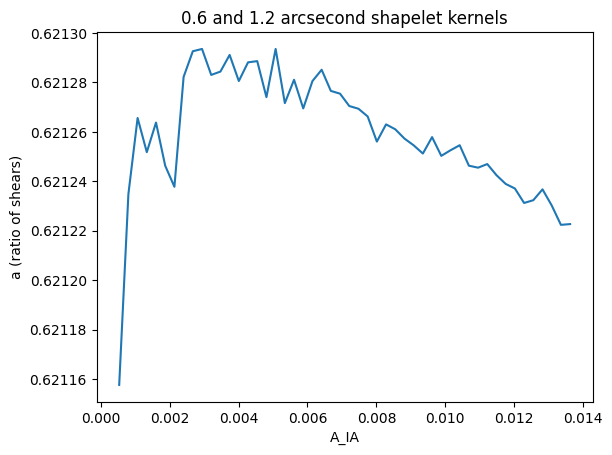

In [42]:
plt.plot(A_IAs, a_amps)
#plt.ylim([0.61,0.63])
plt.xlabel('A_IA')
plt.ylabel('a (ratio of shears)')
plt.title('0.6 and 1.2 arcsecond shapelet kernels')

perc_var = ((max(a_amps) - min(a_amps)) / min(a_amps)) * 100 
print('Max percentage change in a', perc_var)

Max percentage change in estimated yIA 0.1481418972743652


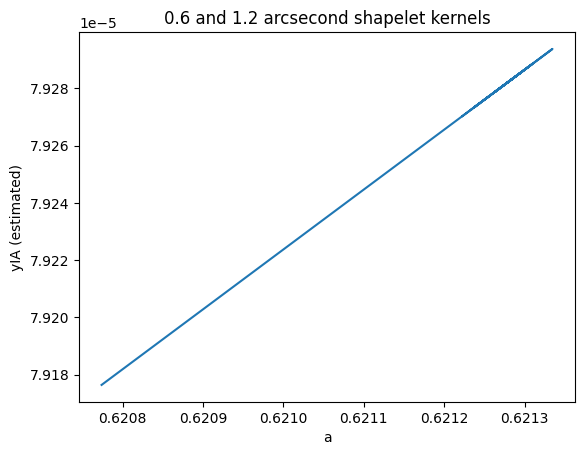

In [40]:
min_diff = min(diffs)
estimated_yIA = min_diff / (1-np.asarray(a_amps))

plt.plot(a_amps, estimated_yIA)
# plt.ylim([0.000158,0.0001584])
plt.xlabel('a')
plt.ylabel('yIA (estimated)')
plt.title('0.6 and 1.2 arcsecond shapelet kernels')

perc_var = ((max(estimated_yIA) - min(estimated_yIA)) / min(estimated_yIA)) * 100 
print('Max percentage change in estimated yIA', perc_var)

In [43]:
def test_scales(scale):

    # fix galaxy size relative to stamp by adding more pixels
    # nn should be 8.533... times large than galaxy
    nn = int((hlr * 8.533333333333333)/scale)

    # apply lensing shear to galaxy
    stamp = Stamp(nn=nn, scale=scale, centering='fpfs')

    # define ia shear as a % of lensing
    ia = IaTransform(center=[0,0], scale=scale, hlr=hlr)
    stamp.transform_grids(ia)
    
    # get galaxy array from stamp object
    gal_array = stamp.sample_galaxy(sersic_gal)
    
    # define PSF
    psf_array = np.zeros(stamp.shape)
    psf_array[nn // 2, nn // 2] = 1
    
    coords = np.array([nn//2, nn//2])
    fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=0.6)
    mms =  fpTask.measure(gal_array, coords)
    mms = fpTask.get_results(mms)
    ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
    resp=np.average(ells['fpfs_R1E'])
    inner_shear=np.average(ells['fpfs_e1'])/resp
    
    fpTask  =   fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=1.2)
    mms =  fpTask.measure(gal_array, coords)
    mms = fpTask.get_results(mms)
    ells=   fpfs.catalog.fpfs_m2e(mms,const=2000)
    resp=np.average(ells['fpfs_R1E'])
    outer_shear=np.average(ells['fpfs_e1'])/resp
    
    a = inner_shear / outer_shear
    
    inner = inner_shear
    outer  = outer_shear
          
    return a, inner, outer 

In [44]:
scales = np.linspace(0.2,0.005,50)

a_scale = []
in_bias_scale = []
out_bias_scale = []

for scale in scales:
    
    a, inner, outer = test_scales(scale)
    
    a_scale.append(a)
    in_bias_scale.append(inner)
    out_bias_scale.append(outer)
    

2023/10/18 21:57:56 ---  Order of the shear estimator: nnord=4
2023/10/18 21:57:56 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:57:56 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:57:56 ---  Order of the shear estimator: nnord=4
2023/10/18 21:57:56 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:57:56 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:57:57 ---  Order of the shear estimator: nnord=4
2023/10/18 21:57:57 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:57:57 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec


0.621557676840587
0.0004919421795205114
0.0007914666616637757


2023/10/18 21:57:57 ---  Order of the shear estimator: nnord=4
2023/10/18 21:57:57 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:57:57 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:57:58 ---  Order of the shear estimator: nnord=4
2023/10/18 21:57:58 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:57:58 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec


0.6215705434850733
0.0004919677356746941
0.0007914913935854948


2023/10/18 21:57:58 ---  Order of the shear estimator: nnord=4
2023/10/18 21:57:58 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:57:58 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:57:59 ---  Order of the shear estimator: nnord=4
2023/10/18 21:57:59 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:57:59 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec


0.6214815747875618
0.0004918676627549982
0.0007914436770279651


2023/10/18 21:57:59 ---  Order of the shear estimator: nnord=4
2023/10/18 21:57:59 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:57:59 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:00 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:00 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:00 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec


0.621477920406476
0.0004918737327917546
0.0007914580979321773


2023/10/18 21:58:00 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:00 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:00 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:00 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:00 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:00 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec


0.6214848704188117
0.0004918694189553858
0.0007914423059469179


2023/10/18 21:58:01 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:01 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:01 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:01 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:01 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:01 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec


0.6214692241330425
0.000491871745484015
0.0007914659751175649


2023/10/18 21:58:02 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:02 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:02 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:02 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:02 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:02 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec


0.6214699977450336
0.000491842134936435
0.0007914173439121028


2023/10/18 21:58:03 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:03 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:03 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:03 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:03 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:03 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec


0.6214580988559881
0.0004918379125154793
0.0007914257025869961


2023/10/18 21:58:03 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:03 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:03 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:04 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:04 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:04 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec


0.6213843402885345
0.0004917730426875563
0.0007914152494721796


2023/10/18 21:58:04 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:04 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:04 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:05 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:05 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:05 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec


0.6214087809688317
0.0004918153859171862
0.0007914522629538678


2023/10/18 21:58:05 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:05 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:05 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6214151495529932
0.0004917982689221526
0.0007914166065566975


2023/10/18 21:58:06 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:06 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:06 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:06 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:06 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:06 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213910333443764
0.0004917612510506342
0.0007913877488767994


2023/10/18 21:58:07 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:07 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:07 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:07 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:07 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:07 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213863600010756
0.0004917749280504431
0.0007914157112325282


2023/10/18 21:58:08 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:08 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:08 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:08 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:08 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:08 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213286032469179
0.0004917279004023415
0.0007914135898986247


2023/10/18 21:58:08 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:08 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:08 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:09 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:09 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:09 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213384215641776
0.000491776762563081
0.0007914797242460335


2023/10/18 21:58:09 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:09 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:09 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:10 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:10 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:10 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213334306900857
0.0004917325312947877
0.0007914148941714654


2023/10/18 21:58:10 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:10 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:10 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:11 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:11 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:11 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213515902386061
0.0004917022114245088
0.0007913429677321491


2023/10/18 21:58:11 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:11 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:11 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:12 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:12 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:12 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213436351580914
0.0004917407505392026
0.0007914151247627838


2023/10/18 21:58:13 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:13 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:13 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:13 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:13 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:13 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213246250447314
0.0004916985771424239
0.0007913714623929877


2023/10/18 21:58:14 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:14 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:14 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:14 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:14 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:14 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213058721748419
0.000491736896780557
0.0007914570243143899


2023/10/18 21:58:15 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:15 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:15 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:15 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:15 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:15 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213093994152792
0.0004917299961092705
0.0007914414244691014


2023/10/18 21:58:16 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:16 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:16 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:16 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:16 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:16 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213440925413248
0.0004917523148732893
0.000791433153990409


2023/10/18 21:58:17 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:17 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:17 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:17 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:17 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:17 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.621286049323006
0.0004916946236087346
0.0007914142352697559


2023/10/18 21:58:18 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:18 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:18 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:19 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:19 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:19 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.621322336024318
0.0004917326972405959
0.0007914292931863148


2023/10/18 21:58:19 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:19 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:19 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:20 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:20 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:20 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213748961884997
0.0004917540959680094
0.0007913967863594401


2023/10/18 21:58:20 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:20 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:20 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:21 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:21 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:21 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6212258336198198
0.0004916910191083757
0.0007914851451739252


2023/10/18 21:58:22 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:22 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:22 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:22 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:22 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:22 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213382248765608
0.0004917097148043461
0.0007913720661593491


2023/10/18 21:58:23 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:23 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:23 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:23 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:23 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:23 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6212459191488146
0.0004916499578419525
0.0007913934606050613


2023/10/18 21:58:24 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:24 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:24 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:25 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:25 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:25 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.62130271398946
0.0004916707821390785
0.0007913546344937088


2023/10/18 21:58:26 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:26 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:26 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:26 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:26 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:26 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213220206763279
0.000491694767779983
0.0007913686484904532


2023/10/18 21:58:27 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:27 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:27 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:28 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:28 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:28 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.621241020145944
0.0004916656904633264
0.000791425025906729


2023/10/18 21:58:28 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:28 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:28 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:29 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:29 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:29 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.621315876888522
0.0004917072757836182
0.0007913966052920318


2023/10/18 21:58:30 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:30 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:30 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:31 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:31 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:31 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213181409706293
0.0004917528497844939
0.0007914670719516941


2023/10/18 21:58:32 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:32 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:32 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:32 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:32 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:32 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6212525020324905
0.0004916569109882202
0.0007913962670246233


2023/10/18 21:58:33 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:33 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:33 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:34 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:34 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:34 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6212686396998798
0.0004916961787197587
0.0007914389159531463


2023/10/18 21:58:35 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:35 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:35 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:36 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:36 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:36 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213148694409202
0.0004916936910081024
0.0007913760239643785


2023/10/18 21:58:37 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:37 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:37 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:38 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:38 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:38 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213386919641289
0.0004917461649370365
0.0007914301351209364


2023/10/18 21:58:40 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:40 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:40 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:40 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:40 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:40 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213063497604243
0.0004917025145149181
0.0007914010772697214


2023/10/18 21:58:42 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:42 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:42 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:43 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:43 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:43 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213401895394105
0.0004916958439577545
0.0007913472397821888


2023/10/18 21:58:45 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:45 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:45 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:46 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:46 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:46 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6212890730333296
0.0004916932038358636
0.0007914080983836751


2023/10/18 21:58:48 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:48 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:48 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:49 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:49 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:49 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6212834252688388
0.0004917003754681703
0.0007914268359169634


2023/10/18 21:58:51 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:51 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:51 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:52 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:52 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:52 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.621266320006954
0.0004916589928028258
0.0007913820160045414


2023/10/18 21:58:56 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:56 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:56 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:58:57 ---  Order of the shear estimator: nnord=4
2023/10/18 21:58:57 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:58:57 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6212146687233565
0.0004916663311910455
0.0007914596289257904


2023/10/18 21:59:01 ---  Order of the shear estimator: nnord=4
2023/10/18 21:59:01 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:59:01 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:59:02 ---  Order of the shear estimator: nnord=4
2023/10/18 21:59:02 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:59:02 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6212532339626622
0.0004917041088353184
0.0007914713066344701


2023/10/18 21:59:07 ---  Order of the shear estimator: nnord=4
2023/10/18 21:59:07 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:59:07 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:59:09 ---  Order of the shear estimator: nnord=4
2023/10/18 21:59:09 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:59:09 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6213223289007502
0.0004917065086869597
0.00079138715255396


2023/10/18 21:59:16 ---  Order of the shear estimator: nnord=4
2023/10/18 21:59:16 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:59:16 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:59:18 ---  Order of the shear estimator: nnord=4
2023/10/18 21:59:18 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:59:18 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6212919714455294
0.0004917124981232284
0.0007914354614613564


2023/10/18 21:59:29 ---  Order of the shear estimator: nnord=4
2023/10/18 21:59:29 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:59:29 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:59:31 ---  Order of the shear estimator: nnord=4
2023/10/18 21:59:31 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:59:31 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.621318271512773
0.000491686425862455
0.0007913599976149212


2023/10/18 21:59:50 ---  Order of the shear estimator: nnord=4
2023/10/18 21:59:50 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:59:50 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 21:59:54 ---  Order of the shear estimator: nnord=4
2023/10/18 21:59:54 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 21:59:54 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6212457633588648
0.0004916807807620404
0.0007914432737596301


2023/10/18 22:00:33 ---  Order of the shear estimator: nnord=4
2023/10/18 22:00:33 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 22:00:33 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 22:00:40 ---  Order of the shear estimator: nnord=4
2023/10/18 22:00:40 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 22:00:40 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6212340007393911
0.0004916830070501877
0.0007914618428241016


2023/10/18 22:02:42 ---  Order of the shear estimator: nnord=4
2023/10/18 22:02:42 ---  Shapelet kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 22:02:42 ---  Detection kernel in configuration space: sigma= 0.6000 arcsec
2023/10/18 22:03:04 ---  Order of the shear estimator: nnord=4
2023/10/18 22:03:04 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/10/18 22:03:04 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


0.6212450452824201
0.0004917039709051778
0.0007914815170584539


Max percentage variation in a 0.05728692183785426


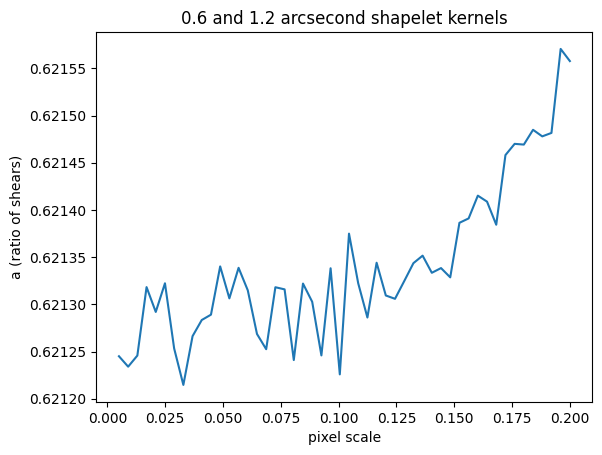

In [45]:
plt.plot(scales, a_scale)
#plt.axhline(np.mean(a_scale), ls='--', c='black')
#plt.ylim([min(a_scale),max(a_scale)])
plt.xlabel('pixel scale')
plt.ylabel('a (ratio of shears)')
plt.title('0.6 and 1.2 arcsecond shapelet kernels')

perc_var = (max(a_scale) - min(a_scale)) / min(a_scale) * 100
print('Max percentage variation in a', perc_var)

Text(0.5, 1.0, 'Measured shear, 0.6 shapelet kernel')

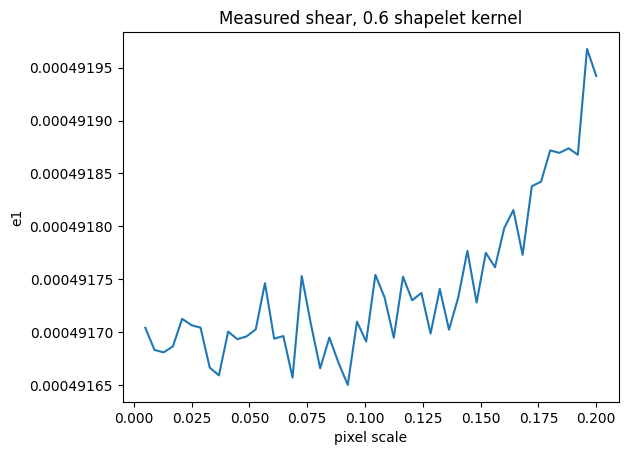

In [48]:
plt.plot(scales, in_bias_scale)
#plt.plot(scales, out_bias_scale)
plt.xlabel('pixel scale')
plt.ylabel('e1')
plt.title('Measured shear, 0.6 shapelet kernel')

Text(0.5, 1.0, 'Measured shear, 1.2 shapelet kernel')

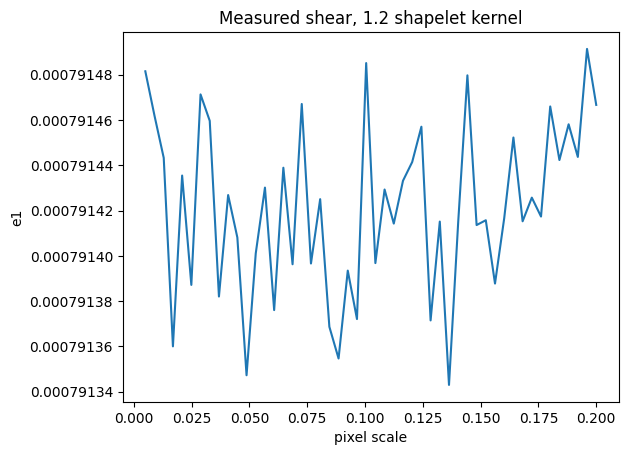

In [49]:
plt.plot(scales, out_bias_scale)
plt.xlabel('pixel scale')
plt.ylabel('e1')
plt.yticks
plt.title('Measured shear, 1.2 shapelet kernel')

## Determine relationship between measurment accuracy at outer radii and hlr / (npixel/2 * scale) ratio
- For a galaxy of given halflight radius we require that the stamp on which it is simulated be X times larger than the galaxy


In [95]:
def test_relative_size(factor):

    # fix galaxy size relative to stamp by adding more pixels
    # nn should be 8.533... times large than galaxy
    nn = 64
    scale = 0.01 * factor

    # apply lensing shear to galaxy
    stamp = Stamp(nn=nn, scale=scale, centering='fpfs')

    ia = IaTransform(beta=0, center=[0,0], scale=scale, hlr=hlr)
    stamp.transform_grids(ia)
    
    # get galaxy array from stamp object
    gal_array = stamp.sample_galaxy(sersic_gal)
    
    # define PSF
    psf_array = np.zeros(stamp.shape)
    psf_array[nn // 2, nn // 2] = 1
    
    fpTask = fpfs.image.measure_source(psf_array, pix_scale = scale, sigma_arcsec=1.2)
    mms = fpTask.measure(gal_array, coords)
    mms = fpTask.get_results(mms)
    ells = fpfs.catalog.fpfs_m2e(mms,const=2000)
    resp = np.average(ells['fpfs_R1E'])
    outer_shear = np.average(ells['fpfs_e1'])/resp

    size_ratio = (nn/2 * scale) / hlr
    bias = abs(outer_shear - AIA_fid)
    print(bias, size_ratio)
    return size_ratio, bias

In [96]:
factors = np.linspace(1,40,40)

size_ratios = []
biases = []
for factor in factors:
    
    size_ratio, bias = test_relative_size(factor)
    size_ratios.append(size_ratio)
    biases.append(bias)

/home/b7009348/FPFS-project/BATSim/src/batsim/transforms.py:110: UserWarning: The stamp provided is only 0.32 times larger than the galaxy. To ensure accurate results, the stamp needs to be at least 2.5 times larger.
  coords_relative = coords - self.ref_vec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:18 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:18 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:18 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 reques

1.868811658141694e+31 0.32


/home/b7009348/FPFS-project/BATSim/src/batsim/transforms.py:110: UserWarning: The stamp provided is only 0.96 times larger than the galaxy. To ensure accurate results, the stamp needs to be at least 2.5 times larger.
  coords_relative = coords - self.ref_vec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:19 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:19 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:19 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 reques

0.0007368903766499759 0.64


/home/b7009348/FPFS-project/BATSim/src/batsim/transforms.py:110: UserWarning: The stamp provided is only 1.28 times larger than the galaxy. To ensure accurate results, the stamp needs to be at least 2.5 times larger.
  coords_relative = coords - self.ref_vec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:19 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:19 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:19 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 reques

0.0008177927481046508 0.96


/home/b7009348/FPFS-project/BATSim/src/batsim/transforms.py:110: UserWarning: The stamp provided is only 1.60 times larger than the galaxy. To ensure accurate results, the stamp needs to be at least 2.5 times larger.
  coords_relative = coords - self.ref_vec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:19 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:19 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:19 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 reques

0.0009731990390450234 1.28


/home/b7009348/FPFS-project/BATSim/src/batsim/transforms.py:110: UserWarning: The stamp provided is only 1.92 times larger than the galaxy. To ensure accurate results, the stamp needs to be at least 2.5 times larger.
  coords_relative = coords - self.ref_vec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:19 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:19 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:19 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 reques

0.001303326463793311 1.6


/home/b7009348/FPFS-project/BATSim/src/batsim/transforms.py:110: UserWarning: The stamp provided is only 2.24 times larger than the galaxy. To ensure accurate results, the stamp needs to be at least 2.5 times larger.
  coords_relative = coords - self.ref_vec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:19 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:19 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:19 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 reques

0.0026641725048428405 1.92


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:20 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:20 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:20 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

0.0024713356517299767 2.24


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:20 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:20 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:20 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

0.0004408154247891237 2.56


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:20 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:20 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:20 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

0.00013942462848101612 2.88


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:20 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:20 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:20 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

4.774976474600169e-05 3.2


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:20 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:20 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:20 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

1.621854023963246e-05 3.52


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:21 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:21 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:21 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

5.293735918936214e-06 3.84


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:21 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:21 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:21 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

1.6374655675022729e-06 4.16


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:21 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:21 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:21 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

5.41817559283138e-07 4.48


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:21 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:21 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:21 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

2.187519228715861e-07 4.8


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:21 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:21 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:21 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

6.713278264129825e-08 5.12


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:22 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:22 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:22 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

1.4915989126132456e-07 5.44


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:22 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:22 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:22 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

1.215805483174891e-07 5.76


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:22 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:22 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:22 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

2.1473629737073837e-07 6.08


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:22 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:22 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:22 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

2.239528028551022e-07 6.4


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:22 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:22 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:22 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

2.653649591796833e-07 6.72


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:23 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:23 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:23 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

3.1017012623764384e-07 7.04


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:23 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:23 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:23 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

4.3223046179697005e-07 7.36


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:23 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:23 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:23 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

4.289953177807936e-07 7.68


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:23 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:23 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:23 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

5.69214134028286e-07 8.0


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:24 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:24 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:24 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

6.693687018818678e-07 8.32


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:24 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:24 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:24 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

8.029806174836415e-07 8.64


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:24 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:24 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:24 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

8.969859457642806e-07 8.96


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:24 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:24 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:24 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

1.0784518332541395e-06 9.28


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:24 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:24 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:24 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

1.2201464108014702e-06 9.6


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:25 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:25 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:25 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

1.43163700005403e-06 9.92


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:25 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:25 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:25 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

1.6078979930144073e-06 10.24


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:25 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:25 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:25 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j

1.8157914487791898e-06 10.56


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:25 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:25 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:25 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


2.0527669144220504e-06 10.88


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = jnp.zeros(data.shape, dtype="complex128")
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:25 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:25 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:25 ---  Detection kernel in c

2.3110264738844576e-06 11.200000000000001


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:26 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:26 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:26 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


2.7037703232172736e-06 11.52


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = jnp.zeros(data.shape, dtype="complex128")
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:26 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:26 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:26 ---  Detection kernel in c

2.9409625878260666e-06 11.84


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:26 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:26 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:26 ---  Detection kernel in configuration space: sigma= 1.2000 arcsec


3.2592257266036723e-06 12.16


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = jnp.zeros(data.shape, dtype="complex128")
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 12:44:26 ---  Order of the shear estimator: nnord=4
2023/11/27 12:44:26 ---  Shapelet kernel in configuration space: sigma= 1.2000 arcsec
2023/11/27 12:44:26 ---  Detection kernel in c

3.636805118750427e-06 12.48


/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = jnp.zeros(data.shape, dtype="complex128")


4.053744023343325e-06 12.8


(-0.0001, 0.002)

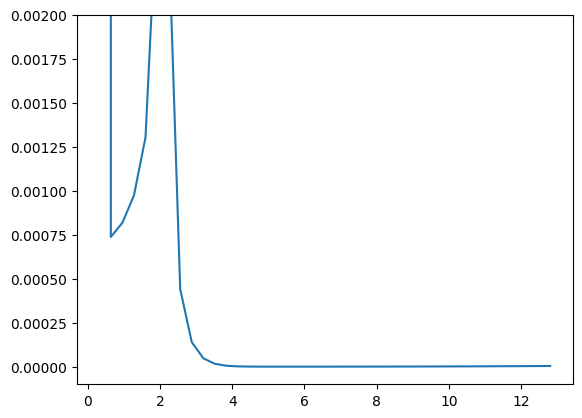

In [98]:
plt.plot(size_ratios, biases)
plt.ylim([-1e-4,0.002])

## Find limits for different shapelet kernels
- The limit will be larger for larger shapelet kernels

In [ ]:
kernels = np.linspace(0.5,1.8,15)
hlrs = np.linspace(0.11, 15, 15)

size_ratios = np.empty([len(hlrs), len(kernels)])
for i, hlr in enumerate(hlrs):
    for j, kernel in enumerate(kernels):
        nn = 128
        init_scale = 0.01
        # create galaxy to be sampled by shear stamp objects
        sersic_gal = galsim.Sersic(n=1.5, half_light_radius=hlr, flux=flux, trunc=trunc)

        bias = 1
        k = 1
        while bias > 1e-6:
            scale = init_scale * k
            # apply lensing shear to galaxy
            stamp = Stamp(nn=nn, scale=scale, centering='fpfs')

            # define ia shear as a % of lensing
            ia = IaTransform(beta=0, center=[0,0], phi=np.radians(0), scale=scale, hlr=hlr)
            stamp.transform_grids(ia)

            # get galaxy array from stamp object
            gal_array = stamp.sample_galaxy(sersic_gal)
            # define PSF
            psf_array = np.zeros(stamp.shape)
            psf_array[nn // 2, nn // 2] = 1

            fpTask = fpfs.image.measure_source(psf_array, pix_scale=scale, sigma_arcsec=kernel)
            mms = fpTask.measure(gal_array, coords)
            mms = fpTask.get_results(mms)
            ells = fpfs.catalog.fpfs_m2e(mms,const=2000)
            resp = np.average(ells['fpfs_R1E'])
            outer_shear = np.average(ells['fpfs_e1'])/resp

            size_ratio = (nn/2 * scale) / hlr
            bias = abs(outer_shear - AIA_fid)
            
            
            k *= 1.5
            
        size_ratios[i,j] = size_ratio

/home/b7009348/FPFS-project/FPFS/fpfs/image.py:119: UserWarning: Explicitly requested dtype <f8 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  psf_data = jnp.array(psf_data, dtype="<f8")
2023/11/27 14:28:29 ---  Order of the shear estimator: nnord=4
2023/11/27 14:28:29 ---  Shapelet kernel in configuration space: sigma= 0.5000 arcsec
2023/11/27 14:28:29 ---  Detection kernel in configuration space: sigma= 0.5000 arcsec
/home/b7009348/FPFS-project/FPFS/fpfs/image.py:195: UserWarning: Explicitly requested dtype complex128 requested in zeros is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  out = j